In [1]:
!pip install tqdm --upgrade --force-reinstall --quiet
!pip install seaborn --quiet
!pip uninstall -y enum34 --quiet
!pip install --upgrade --force-reinstall torch torchvision --quiet
!pip install pytorch-lightning --quiet
!pip install pytorch-lightning-bolts --quiet
!pip install --upgrade --force-reinstall wandb --quiet

ERROR: pytorch-lightning 1.1.7 has requirement PyYAML!=5.4.*,>=5.1, but you'll have pyyaml 5.4.1 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
ERROR: pytorch-lightning 1.1.7 has requirement PyYAML!=5.4.*,>=5.1, but you'll have pyyaml 5.4.1 which is incompatible.
ERROR: aiohttp 3.7.3 has requirement chardet<4.0,>=2.0, but you'll have chardet 4.0.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
ERROR: pytorch-lightning 1.1.7 has requirement PyYAML!=5.4.*,>=5.1, but you'll have pyyaml 5.4.1 which is incompatible.
ERROR: aiohttp 3.7.3 has requirement chardet<4.0,>=2.0, but you'll have chardet 4.0.0 which is incompatible.
You should consider upgrading via the 'pip inst

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from tqdm.auto import tqdm
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.metrics.functional import accuracy, stat_scores_multiple_classes
from pytorch_lightning.loggers import WandbLogger

import pl_bolts
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

import wandb

/usr/local/lib/python3.6/dist-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  f' install it with `pip install {pypi_name}`.' + extra_text


## Load the data (CIFAR-10)

In [3]:
CIFAR10_CLASSES = ['airplane', 
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck']


def instantiate_datamodule(batch_size=128, train_transforms=None, test_transforms=None):
    
    if train_transforms is None:
        train_transforms = []
    train_transforms += [torchvision.transforms.ToTensor(),
                         cifar10_normalization()]

    if test_transforms is None:
        test_transforms = []
    test_transforms += [torchvision.transforms.ToTensor(),
                        cifar10_normalization()]

    cifar10_dm = pl_bolts.datamodules.CIFAR10DataModule(
        batch_size=batch_size,
        train_transforms=torchvision.transforms.Compose(train_transforms),
        test_transforms=torchvision.transforms.Compose(test_transforms),
        val_transforms=torchvision.transforms.Compose(test_transforms),
    )

    return cifar10_dm

cifar10_dm = instantiate_datamodule()

## Create the Myrtle5 model

In [4]:
class LitMyrtle5(pl.LightningModule):
    
    def __init__(self, lr=0.1, c=64, num_classes=10):
        
        super().__init__()

        self.save_hyperparameters()
        
        self.sequential_module = nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),
        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # Layer 4
        nn.MaxPool2d(4),    
        nn.Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
        )
        
    def forward(self, x):
        output = self.sequential_module(x)
        return output
    
    def _evaluate(self, batch, batch_idx, stage=None):
        x, y = batch
        output = self.forward(x)
        loss = F.cross_entropy(output, y)
        preds = torch.argmax(output, dim=-1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_acc', acc, prog_bar=True)
        
        tps, fps, tns, fns, sups = stat_scores_multiple_classes(preds, y)
        for class_index, (tp, sup) in enumerate(zip(tps, sups)):
            self.log(f'{stage}_tps_{class_index}', tp, reduce_fx=torch.sum)
            self.log(f'{stage}_sups_{class_index}', sup, reduce_fx=torch.sum)
        
        return {'loss': loss, 'acc': acc}

    def training_step(self, batch, batch_idx):
        # x, y = batch
        # output = self.forward(x)
        # loss = F.cross_entropy(output, y)
        # self.log('train_loss', loss, on_step=True, prog_bar=True)
        return self._evaluate(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._evaluate(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        self._evaluate(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.lr)
    
    ####### NOTE #######
    # The progress bar of PyTorch Lightning doesn't work in my Paperspace instance
    # So I'm printing the loss/acc values here
    def _print_epoch_end(self, step_outputs, stage):
        loss, acc = zip(*((step['loss'], step['acc']) for step in step_outputs))
        print(f'{stage} loss: {torch.stack(loss).mean():.3f}')
        print(f'{stage} acc: {torch.stack(acc).mean():.3f}')

    def training_epoch_end(self, step_outputs):
        self._print_epoch_end(step_outputs, 'train')

    def validation_epoch_end(self, step_outputs):
        self._print_epoch_end(step_outputs, 'val')

## Training

In [5]:
orig_model = LitMyrtle5()

wandb_logger = WandbLogger(name='q1-robustnesss-original', project='mltheoryseminar-hw0')
orig_trainer = Trainer(max_epochs=20, gpus=1, progress_bar_refresh_rate=20, logger=wandb_logger)

orig_trainer.fit(orig_model, cifar10_dm)

wandb.finish();

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: shlomihod (use `wandb login --relogin` to force relogin)



  | Name              | Type       | Params
-------------------------------------------------
0 | sequential_module | Sequential | 1.6 M 
-------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

val loss: 2.303
val acc: 0.098


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val loss: 1.888
val acc: 0.373
train loss: 2.419
train acc: 0.272


Validating: 0it [00:00, ?it/s]

val loss: 1.740
val acc: 0.431
train loss: 1.533
train acc: 0.442


Validating: 0it [00:00, ?it/s]

val loss: 1.732
val acc: 0.479
train loss: 1.269
train acc: 0.547


Validating: 0it [00:00, ?it/s]

val loss: 1.455
val acc: 0.528
train loss: 1.081
train acc: 0.620


Validating: 0it [00:00, ?it/s]

val loss: 1.378
val acc: 0.564
train loss: 0.932
train acc: 0.677


Validating: 0it [00:00, ?it/s]

val loss: 1.394
val acc: 0.584
train loss: 0.805
train acc: 0.723


Validating: 0it [00:00, ?it/s]

val loss: 1.170
val acc: 0.671
train loss: 0.702
train acc: 0.760


Validating: 0it [00:00, ?it/s]

val loss: 0.937
val acc: 0.686
train loss: 0.611
train acc: 0.795


Validating: 0it [00:00, ?it/s]

val loss: 1.187
val acc: 0.674
train loss: 0.539
train acc: 0.823


Validating: 0it [00:00, ?it/s]

val loss: 0.674
val acc: 0.782
train loss: 0.451
train acc: 0.852


Validating: 0it [00:00, ?it/s]

val loss: 0.876
val acc: 0.743
train loss: 0.395
train acc: 0.873


Validating: 0it [00:00, ?it/s]

val loss: 0.711
val acc: 0.783
train loss: 0.318
train acc: 0.900


Validating: 0it [00:00, ?it/s]

val loss: 0.787
val acc: 0.776
train loss: 0.274
train acc: 0.915


Validating: 0it [00:00, ?it/s]

val loss: 1.601
val acc: 0.721
train loss: 0.195
train acc: 0.944


Validating: 0it [00:00, ?it/s]

val loss: 0.681
val acc: 0.808
train loss: 0.135
train acc: 0.965


Validating: 0it [00:00, ?it/s]

val loss: 0.644
val acc: 0.826
train loss: 0.067
train acc: 0.985


Validating: 0it [00:00, ?it/s]

val loss: 0.615
val acc: 0.837
train loss: 0.020
train acc: 0.998


Validating: 0it [00:00, ?it/s]

val loss: 0.602
val acc: 0.846
train loss: 0.007
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.603
val acc: 0.846
train loss: 0.004
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.607
val acc: 0.848
train loss: 0.003
train acc: 1.000


train_loss,0.0018
train_acc,1.0
train_tps_0,13.0
train_sups_0,13.0
train_tps_1,15.0
train_sups_1,15.0
train_tps_2,11.0
train_sups_2,11.0
train_tps_3,18.0
train_sups_3,18.0
train_tps_4,7.0


train_loss,█▇▆▆▅▅▄▅▄▄▄▃▃▃▄▃▃▃▂▂▂▂▃▂▂▅▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▃▄▅▄▅▅▅▆▆▇▅▆▆▆▇▇▇▇▆▇█▇██▇███████████
train_tps_0,▁▂▂▄▆▇▃▆▄▃▆▄█▅▅▇▆▅█▆▅▁▅▆▅▅▆▄▄▇▇█▇▄▆▇██▆▇
train_sups_0,▅▄▃▆█▅▅▄▂▃▅▃█▅▆▇▆▂█▆▂▁▅▅▄▄▅▁▂▆▅▇▅▁▄▅▇▇▄▅
train_tps_1,▁▁▃▄▃▂▃▄▃▅▅▆▄▅▅██▄▅▄▇▅▄▆▆▅▅▆▄▆▄▃▅█▅▆▅▄▂▅
train_sups_1,▄▄▄▂▄▃▄▇▄▅▄▅▆▅▄█▇▄▄▃▆▄▃▅▅▄▄▅▃▅▃▂▄▇▄▅▄▃▁▄
train_tps_2,▁▁▁▁▂▃▅▄▃█▄▅▃▅▄▃▄▄▄▅▆▅▅▆▅▅▆▆▆▇▆▄▅▆▅▄█▇▅▅
train_sups_2,▅▄▃▄▁▁▄▄▄█▆▅▂▃▂▃▅▃▃▄▅▃▄▄▄▅▅▅▅▅▅▂▄▄▃▁▇▆▄▃
train_tps_3,▃▆▃▅▃▁▃▆▃▅▃▃▂▆▃▃▅▂▅▅▅▆▃▄▅▁▇▅▆▅▅▆▅▆██▄▆▆▆
train_sups_3,▄█▄▅▅▅▃▆▄▅▂▄▅▇▅▁▅▃▄▃▇▅▃▆▄▃▇▄▆▄▃▄▃▅▇▇▂▅▅▅
train_tps_4,▁▁▆▂▃▄▄▂▄▁▂▄▃▃▄▄▄▅▄▄▅▅▆▅▅▆▅▇▇▄▇█▅▇▅█▅▆▇▄


## Q1: Robustness

In [32]:
vertical_flip_cifar10_dm = instantiate_datamodule(test_transforms=[torchvision.transforms.RandomVerticalFlip(1)])

def enrich_with_per_class_accuracy(results, stage='test'):
    assert np.isclose(sum([results[metric] for metric in results if 'tps' in metric])
                      / sum([results[metric] for metric in results if 'sups' in metric]),
             results[f'{stage}_acc'])
    
    for class_index in range(10):
        results[f'{stage}_acc_{class_index}'] = (results[f'{stage}_tps_{class_index}']
                                                 / results[f'{stage}_sups_{class_index}'])
        
    return results


def evaluate_vertical_flip_robustness(model):
    trainer = Trainer(gpus=1)
    
    robustness_results = {}
    
    for tag, dm in (('og', cifar10_dm),
                    ('vf', vertical_flip_cifar10_dm)):
        test_results = trainer.test(model, datamodule=dm, verbose=False)[0]
        robustness_results[tag] = enrich_with_per_class_accuracy(test_results)
        
    robustness_results['diff'] = {metric:
                                  (robustness_results['og'][metric]
                                   -  robustness_results['vf'][metric])
                                  for metric in robustness_results['og']}

    return robustness_results


def plot_vertical_flip_robustness(results, path=None):

    df = ((pd.DataFrame(results)
          .filter(like='acc', axis=0)
          .set_axis(['Overall'] + [name.title() for name in  CIFAR10_CLASSES],
                    inplace=False)
          * 100)
          .sort_values(by='diff', ascending=True))
    
    print('Original CIFAR-10 Test Accuracy: ', df.loc['Overall', 'og'])
    print('Vertially flipped CIFAR-10 Test Accuracy: ', df.loc['Overall', 'vf'])

    df = df['diff']

    overall_index = df.index.get_loc('Overall')
    
    display(df)
    
    colors = ['C0'] * overall_index + ['C1'] + ['C0'] * (10-overall_index)

    ax = df.plot(kind='barh', color=colors)

    ax.set_xlabel('Difference in percentage points')
    ax.set_ylabel('Class')
    ax.set_xlim(0, 100)
    
    print('XXXXX', path)
    if path is not None:
        plt.tight_layout()
        plt.savefig(path, dpi=300)
    
    return ax


def report_vertical_flip_robustness_evaluation(model, path=None):
    with sns.plotting_context('notebook', font_scale=1.5):
        return plot_vertical_flip_robustness(evaluate_vertical_flip_robustness(model), path)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Testing: 0it [00:00, ?it/s]

Original CIFAR-10 Test Accuracy:  83.56000185012817
Vertially flipped CIFAR-10 Test Accuracy:  42.71000027656555


Airplane      11.600000
Frog          18.400000
Cat           30.300000
Dog           31.300000
Deer          36.800000
Bird          36.900000
Overall       40.850002
Truck         43.400000
Automobile    61.400000
Ship          62.400000
Horse         76.000000
Name: diff, dtype: float64

XXXXX figures/q1-org.png


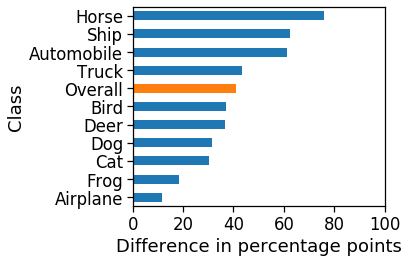

In [33]:
report_vertical_flip_robustness_evaluation(orig_model, path='figures/q1-org.png');

In [18]:
aug_model = LitMyrtle5()

aug_cifar10_dm = instantiate_datamodule(train_transforms=[torchvision.transforms.RandomVerticalFlip(0.5)])

aug_wandb_logger = WandbLogger(name='q1-robustnesss-augmented', project='mltheoryseminar-hw0')
aug_trainer = Trainer(max_epochs=50, gpus=1, progress_bar_refresh_rate=20, logger=aug_wandb_logger)

aug_trainer.fit(aug_model, aug_cifar10_dm)

wandb.finish();

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



  | Name              | Type       | Params
-------------------------------------------------
0 | sequential_module | Sequential | 1.6 M 
-------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

val loss: 2.310
val acc: 0.098


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val loss: 2.241
val acc: 0.265
train loss: 2.774
train acc: 0.258


Validating: 0it [00:00, ?it/s]

val loss: 2.299
val acc: 0.302
train loss: 1.620
train acc: 0.408


Validating: 0it [00:00, ?it/s]

val loss: 1.799
val acc: 0.432
train loss: 1.393
train acc: 0.494


Validating: 0it [00:00, ?it/s]

val loss: 1.744
val acc: 0.476
train loss: 1.231
train acc: 0.560


Validating: 0it [00:00, ?it/s]

val loss: 1.319
val acc: 0.547
train loss: 1.105
train acc: 0.606


Validating: 0it [00:00, ?it/s]

val loss: 1.257
val acc: 0.562
train loss: 0.998
train acc: 0.645


Validating: 0it [00:00, ?it/s]

val loss: 1.078
val acc: 0.615
train loss: 0.917
train acc: 0.676


Validating: 0it [00:00, ?it/s]

val loss: 1.086
val acc: 0.623
train loss: 0.849
train acc: 0.701


Validating: 0it [00:00, ?it/s]

val loss: 1.019
val acc: 0.651
train loss: 0.786
train acc: 0.728


Validating: 0it [00:00, ?it/s]

val loss: 0.949
val acc: 0.680
train loss: 0.726
train acc: 0.748


Validating: 0it [00:00, ?it/s]

val loss: 0.880
val acc: 0.698
train loss: 0.669
train acc: 0.770


Validating: 0it [00:00, ?it/s]

val loss: 0.892
val acc: 0.702
train loss: 0.620
train acc: 0.787


Validating: 0it [00:00, ?it/s]

val loss: 0.881
val acc: 0.709
train loss: 0.580
train acc: 0.800


Validating: 0it [00:00, ?it/s]

val loss: 0.861
val acc: 0.722
train loss: 0.533
train acc: 0.818


Validating: 0it [00:00, ?it/s]

val loss: 0.697
val acc: 0.768
train loss: 0.488
train acc: 0.836


Validating: 0it [00:00, ?it/s]

val loss: 0.916
val acc: 0.718
train loss: 0.446
train acc: 0.851


Validating: 0it [00:00, ?it/s]

val loss: 0.783
val acc: 0.747
train loss: 0.427
train acc: 0.863


Validating: 0it [00:00, ?it/s]

val loss: 0.772
val acc: 0.751
train loss: 0.370
train acc: 0.878


Validating: 0it [00:00, ?it/s]

val loss: 0.743
val acc: 0.766
train loss: 0.352
train acc: 0.885


Validating: 0it [00:00, ?it/s]

val loss: 0.726
val acc: 0.771
train loss: 0.313
train acc: 0.899


Validating: 0it [00:00, ?it/s]

val loss: 0.719
val acc: 0.783
train loss: 0.264
train acc: 0.914


Validating: 0it [00:00, ?it/s]

val loss: 0.733
val acc: 0.777
train loss: 0.250
train acc: 0.921


Validating: 0it [00:00, ?it/s]

val loss: 0.797
val acc: 0.777
train loss: 0.190
train acc: 0.940


Validating: 0it [00:00, ?it/s]

val loss: 0.708
val acc: 0.796
train loss: 0.194
train acc: 0.942


Validating: 0it [00:00, ?it/s]

val loss: 0.758
val acc: 0.784
train loss: 0.158
train acc: 0.953


Validating: 0it [00:00, ?it/s]

val loss: 1.493
val acc: 0.689
train loss: 0.104
train acc: 0.969


Validating: 0it [00:00, ?it/s]

val loss: 0.741
val acc: 0.795
train loss: 0.093
train acc: 0.974


Validating: 0it [00:00, ?it/s]

val loss: 0.778
val acc: 0.795
train loss: 0.060
train acc: 0.985


Validating: 0it [00:00, ?it/s]

val loss: 0.728
val acc: 0.806
train loss: 0.065
train acc: 0.985


Validating: 0it [00:00, ?it/s]

val loss: 0.732
val acc: 0.808
train loss: 0.026
train acc: 0.995


Validating: 0it [00:00, ?it/s]

val loss: 0.720
val acc: 0.813
train loss: 0.018
train acc: 0.997


Validating: 0it [00:00, ?it/s]

val loss: 0.729
val acc: 0.815
train loss: 0.012
train acc: 0.999


Validating: 0it [00:00, ?it/s]

val loss: 0.735
val acc: 0.816
train loss: 0.008
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.728
val acc: 0.817
train loss: 0.006
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.727
val acc: 0.820
train loss: 0.005
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.728
val acc: 0.820
train loss: 0.003
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.731
val acc: 0.820
train loss: 0.003
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.736
val acc: 0.821
train loss: 0.002
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.740
val acc: 0.821
train loss: 0.002
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.741
val acc: 0.821
train loss: 0.002
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.744
val acc: 0.821
train loss: 0.002
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.745
val acc: 0.821
train loss: 0.002
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.749
val acc: 0.820
train loss: 0.002
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.751
val acc: 0.820
train loss: 0.001
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.753
val acc: 0.821
train loss: 0.001
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.755
val acc: 0.821
train loss: 0.001
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.757
val acc: 0.820
train loss: 0.001
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.758
val acc: 0.821
train loss: 0.001
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.761
val acc: 0.820
train loss: 0.001
train acc: 1.000


Validating: 0it [00:00, ?it/s]

val loss: 0.763
val acc: 0.820
train loss: 0.001
train acc: 1.000


train_loss,0.00041
train_acc,1.0
train_tps_0,3.0
train_sups_0,3.0
train_tps_1,10.0
train_sups_1,10.0
train_tps_2,7.0
train_sups_2,7.0
train_tps_3,8.0
train_sups_3,8.0
train_tps_4,7.0


train_loss,██▆▅▅▄▄▄▄▅▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▅▅▅▅▅▅▆▇▆▇▇▇██▇█████████████████████
train_tps_0,▁▂▆▅▅▆▆▅▄▄▄▄▅▅▆▇▃▅▄▅▅▅▆▅█▄▆▄█▆▇▆▄▆▇▆▇▅▇█
train_sups_0,▃▅▅▆▄▆▆▆▂▃▃▄▅▅▅▇▁▃▂▃▄▃▅▃█▂▅▂▇▅▆▅▂▅▆▅▇▄▆▇
train_tps_1,▁▅▂▅▄▄█▅▆▄▅▄▃▇▆▅▇▆▄▅▅▆▆▅▄▅▆▇▆▇▆▄▆▅▅▆▅▆▇▆
train_sups_1,▂▃▁▃▃▃█▃▅▃▂▁▁▆▄▃▅▅▁▃▂▃▄▃▁▃▃▅▄▆▃▁▅▃▃▅▃▅▅▃
train_tps_2,▁▁▃▄▅▃▃▅▆▂▄▆▅▅▃▅▅▇▆▆▅▇▆▃▅▅▅▇▅▆▆▅▄▆▅▆▅▅▅█
train_sups_2,▅▅▂▄▇▄▄▅▇▅▆▅▆▄▂▄▄▆▅▅▄▇▅▁▄▄▃▆▃▅▅▄▃▅▃▅▃▄▃█
train_tps_3,▄▁▁▁▁▂▂▂▃▂▁▄▁▃▄▃▄▅▃▅▄▆▅▅▇▆▆▇▄▄▇▇█▇▄▄▄█▅▄
train_sups_3,▇▅▅▅▂▅▁▅▇▅▃▆▃▃▇▃▂▃▃▄▃▅▄▄▇▅▅▆▃▃▇▇█▆▂▃▂▇▅▃
train_tps_4,▁▇▄▃▂▅▃▃▄▂▆▆▆▅▇▄▇▃▄▆▆▃█▆▅▄▅▇▆▅▄▆▆▅▄▅▄▅▅▄


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Original CIFAR-10 Test Accuracy:  81.91999793052673
Vertially flipped CIFAR-10 Test Accuracy:  81.51000142097473


Automobile   -0.600000
Horse        -0.300000
Frog         -0.200000
Airplane      0.000000
Bird          0.000000
Truck         0.200000
Overall       0.409997
Ship          0.800000
Cat           0.900000
Dog           1.300000
Deer          2.000000
Name: diff, dtype: float64

XXXXX figures/q1-aug.png


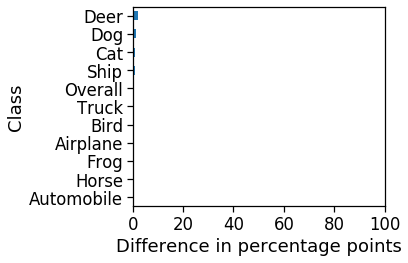

In [34]:
report_vertical_flip_robustness_evaluation(aug_model, path='figures/q1-aug.png');

![](./figures/cifar10.png)

## Q2: Random Labels

In [10]:
from pl_bolts.datasets.cifar10_dataset import CIFAR10
from pl_bolts.datamodules import CIFAR10DataModule

def random_label_cifar10_datamodule_factory(prob, seed=42):

    class RandomLabelCIFAR10(CIFAR10):
        def __init__(self, *args, **kwds):
            super().__init__(*args, **kwds)

            np.random.seed(seed)

            self.is_randomized = np.random.choice([True, False],
                                                  size=len(self.targets),
                                                  p=[prob, 1-prob]) 

            self.random_labels = np.random.randint(0, len(self.labels),
                                                   size=len(self.targets))

        def __getitem__(self, idx):
            img, target = super().__getitem__(idx)
            target = self.random_labels[idx] if self.is_randomized[idx] else target
            return img, target


    class RandomLabelCIFAR10DataModule(CIFAR10DataModule):
        dataset_cls = RandomLabelCIFAR10

    
    return RandomLabelCIFAR10DataModule


def instantiate_random_labels_datamodule(prob=0, seed=42, batch_size=128):
    
    transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 cifar10_normalization()])

    cifar10_dm = random_label_cifar10_datamodule_factory(prob, seed)(
        batch_size=batch_size,
        train_transforms=transforms,
        test_transforms=transforms,
        val_transforms=transforms,
    )

    return cifar10_dm


def test_random_labels_datamodule():
    
    dm0 = instantiate_random_labels_datamodule(0)
    dm0.prepare_data()
    dm0.setup('fit')

    dm1 = instantiate_random_labels_datamodule(0.5)
    dm1.prepare_data()
    dm1.setup('fit')

    hits = [np.mean(targets0.numpy() == targets1.numpy())
            for (_, targets0), (_, targets1) in zip(dm0.train_dataloader(), dm1.train_dataloader())]

    np.testing.assert_almost_equal(np.mean(hits), 0.5 * 1 + 0.5 * 0.1, decimal=2)


test_random_labels_datamodule()

In [11]:
if False:
    for prob in [0, 0.5, 1]:
        for c in [64, 4]:
            for lr in 0.1**(np.arange(1, 4)):
                name = f'q2-random-labels-p{prob}-c{c}'

                dm = instantiate_random_labels_datamodule(prob=prob)
                model = LitMyrtle5(c=c, lr=lr)

                wandb_logger = WandbLogger(name=name, project='mltheoryseminar-hw0')
                trainer = Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=20, logger=wandb_logger)

                trainer.fit(model, dm)
                trainer.test(model, datamodule=dm, verbose=False)

                wandb.finish();

In [12]:
# https://wandb.ai/shlomihod/mltheoryseminar-hw0/table?workspace=user-
# fitler for `q2` in name and remove the `hidden` tag

RESULTS ={'p': {1: 0.0, 2: 0.0, 3: 0.5, 4: 1.0, 5: 0.5, 6: 1.0},
 'c': {1: 64, 2: 4, 3: 4, 4: 4, 5: 64, 6: 64},
 'train_acc': {1: 1.0, 2: 0.859375, 3: 0.5, 4: 0.296875, 5: 1.0, 6: 1.0},
 'val_acc': {1: 0.8468999862670898,
  2: 0.6521999835968018,
  3: 0.2892000079154968,
  4: 0.10329999774694444,
  5: 0.3133000135421753,
  6: 0.09700000286102296},
 'test_acc': {1: 0.8400999903678894,
  2: 0.6473000049591064,
  3: 0.2930000126361847,
  4: 0.09730000048875807,
  5: 0.30959999561309814,
  6: 0.10530000180006029},
 'train_loss': {1: 8.783841622062027e-05,
  2: 0.3708679378032684,
  3: 1.578813910484314,
  4: 1.9849663972854616,
  5: 0.001846500439569354,
  6: 0.00012222242366988212},
 'val_loss': {1: 0.6908100843429565,
  2: 1.0504761934280396,
  3: 2.1919384002685547,
  4: 2.4187171459198,
  5: 4.138575077056885,
  6: 6.51561260223388},
 'test_loss': {1: 0.7412284016609192,
  2: 1.0757910013198853,
  3: 2.1741461753845215,
  4: 2.4185917377471924,
  5: 4.1815314292907715,
  6: 6.439663410186768},
 'epoch': {1: 99, 2: 99, 3: 99, 4: 99, 5: 55, 6: 199},
 'lr': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1}}

random_label_results_df = pd.DataFrame(RESULTS)

random_label_results_df['error_train'] = 1 - random_label_results_df['train_acc']
random_label_results_df['error_test'] = 1 - random_label_results_df['test_acc']

random_label_results_df = random_label_results_df[['p', 'c', 'error_train', 'error_test']]
random_label_results_df['p'] = (random_label_results_df['p'] * 100).astype(int)


long_random_label_results_df = random_label_results_df.melt(id_vars=['p', 'c'],
                                                            value_vars=['error_train', 'error_test'],
                                                            var_name='stage',
                                                            value_name='error')

long_random_label_results_df['stage'] = (long_random_label_results_df['stage']
                                         .apply(lambda x: {'error_train': 'Training',
                                                           'error_test': 'Test'}[x]))

long_random_label_results_df = long_random_label_results_df.rename({'stage': 'Stage',
                                                                    'error': 'Error (%)',
                                                                    'p': 'Random labels (%)',
                                                                    'c': 'Capacity parameter'}, axis=1)

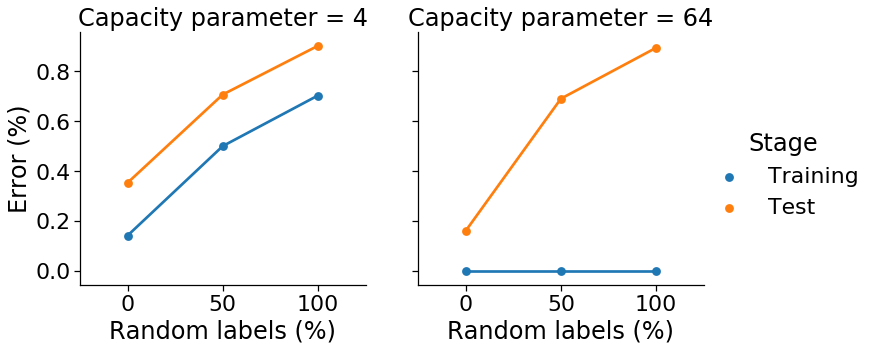

In [13]:
with sns.plotting_context('notebook', font_scale=2):

    sns.catplot(x='Random labels (%)', y='Error (%)', hue='Stage', col='Capacity parameter',
                kind='point', label='big',
                data=long_random_label_results_df);
    
    plt.savefig('figures/q2-comparision.png', dpi=300)